In [1]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
np.random.seed(0)

print(tf.__version__)
print(keras.__version__)

2.3.0
2.4.0


In [3]:
image_datas = glob('C:/Users/smhrd/DeepStudy/num/*/*.jpg')
class_name = ["n0","n1","n2","n3","n4","n5","n6","n7","n8","n9"]
dic = {"n0":0, "n1":1, "n2":2, "n3":3, "n4":4, "n5":5, "n6":6, "n7":7,"n8":8,"n9":9}

In [4]:
image_datas[3000]
image_datas[3000].replace('\\','/')
image_datas[3000]

'C:/Users/smhrd/DeepStudy/num\\n7\\0367_jpg.rf.880349e7f4ccf3b447f1b6d0521a7ec1.jpg'

In [5]:
X=[]
Y=[]
for imagename in image_datas:
    image = cv2.imread(imagename, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (30,60))
    image = np.array(image)
    X.append(image)
    label = imagename.split('\\')[1]
    label = dic[label]
    Y.append(label)

error: OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [9]:
imagename.split('\\')[1]

'n9'

In [13]:
imagename

'C:/Users/smhrd/DeepStudy/num\\n9\\485_jpg.rf.d5fab5f9ba858d11f4d8de96e96f2a9a.jpg'

In [13]:
X = np.array(X)
Y = np.array(Y)

In [14]:
train_images, test_images, train_labels, test_labels = train_test_split(X, Y, 
                                                                        test_size=0.2,
                                                                        shuffle=True,
                                                                        random_state=1)
train_labels = train_labels[..., tf.newaxis]
test_labels = test_labels[..., tf.newaxis]

train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((3292, 60, 30, 3), (823, 60, 30, 3), (3292, 1), (823, 1))

In [15]:
# train set의 각 class별 image 수 확인
unique, counts = np.unique(np.reshape(train_labels, (3292,)), axis=-1, return_counts=True)
dict(zip(unique, counts))

{0: 407,
 1: 393,
 2: 345,
 3: 275,
 4: 331,
 5: 333,
 6: 295,
 7: 239,
 8: 382,
 9: 292}

In [16]:
# test set의 각 class별 image 수 확인
unique, counts = np.unique(np.reshape(test_labels, (823,)), axis=-1, return_counts=True)
dict(zip(unique, counts))

{0: 106, 1: 99, 2: 90, 3: 69, 4: 84, 5: 87, 6: 83, 7: 53, 8: 74, 9: 78}

In [17]:
N_TRAIN = train_images.shape[0]
N_TEST = test_images.shape[0]
print(N_TRAIN, N_TEST)

3292 823


In [18]:
train_images.shape

(3292, 60, 30, 3)

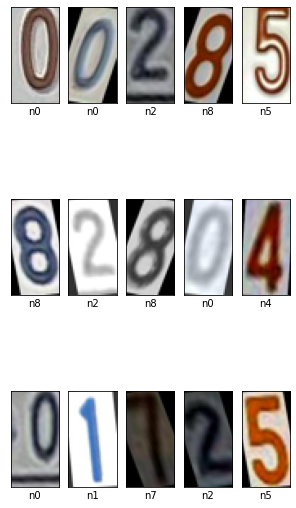

In [19]:
## Data확인
plt.figure(figsize=(5,10))
for i in range(15):
    img_idx = np.random.randint(0,3292)
    plt.subplot(3,5,i+1)  #여러개의 그래프를 하나의 그림에 나타냄
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[img_idx])
    plt.xlabel(class_name[train_labels[img_idx][0]])

In [20]:
# pixel 값을 0~1 사이 범위로 조정
train_images = train_images.astype(np.float32)/255.
test_images = test_images.astype(np.float32)/255.

#label을 onehot-encoding
train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)

In [21]:
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(3292, 60, 30, 3) (3292, 10)
(823, 60, 30, 3) (823, 10)


In [22]:
# Hyper-parameters
learning_rate = 0.001
N_EPOCHS = 20
N_BATCH = 100
N_CLASS = 10

In [23]:
# dataset 구성
train_dataset = tf.data.Dataset.from_tensor_slices((train_images,
                                                    train_labels)).shuffle(buffer_size=3292).batch(N_BATCH).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_images,
                                                   test_labels)).batch(N_BATCH)

In [24]:
# Sequential API를 사용하여 model구성
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3,
                                 activation='relu', padding='SAME',
                                 input_shape=(30,60,3)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3,
                                 activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3,
                                 activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256,activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    
    model.add(keras.layers.Dense(10,activation='softmax'))
    return model

In [25]:
# Create model, compile, summary
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 60, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 15, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 15, 128)        73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [26]:
# Parameters for training
steps_per_epoch = N_TRAIN//N_BATCH
validation_steps = int(np.ceil(N_TEST//N_BATCH))
print(steps_per_epoch, validation_steps)

32 8


In [27]:
# train
history = model.fit(train_dataset, epochs=N_EPOCHS, steps_per_epoch=steps_per_epoch,
                   validation_data=test_dataset, validation_steps=validation_steps)

Epoch 1/20
32/32 [==============================] - 6s 178ms/step - loss: 2.1751 - accuracy: 0.2138 - val_loss: 1.5853 - val_accuracy: 0.5775
Epoch 2/20
32/32 [==============================] - 6s 179ms/step - loss: 1.0310 - accuracy: 0.6758 - val_loss: 0.4533 - val_accuracy: 0.8825
Epoch 3/20
32/32 [==============================] - 6s 178ms/step - loss: 0.3901 - accuracy: 0.8900 - val_loss: 0.1915 - val_accuracy: 0.9475
Epoch 4/20
32/32 [==============================] - 6s 180ms/step - loss: 0.1988 - accuracy: 0.9395 - val_loss: 0.0984 - val_accuracy: 0.9812
Epoch 5/20
32/32 [==============================] - 6s 184ms/step - loss: 0.1361 - accuracy: 0.9574 - val_loss: 0.0697 - val_accuracy: 0.9912
Epoch 6/20
32/32 [==============================] - 6s 182ms/step - loss: 0.0923 - accuracy: 0.9724 - val_loss: 0.0590 - val_accuracy: 0.9912
Epoch 7/20
32/32 [==============================] - 6s 189ms/step - loss: 0.0649 - accuracy: 0.9803 - val_loss: 0.0388 - val_accuracy: 0.9950
Epoch 

In [28]:
model.save('num_model.h5')

In [29]:
model.evaluate(test_dataset)

9/9 [==============================] - 0s 18ms/step - loss: 0.0495 - accuracy: 0.9927


[0.04953606054186821, 0.9927095770835876]

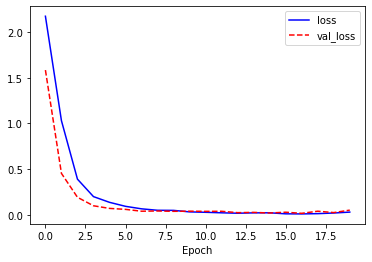

In [30]:
# Plot losses
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

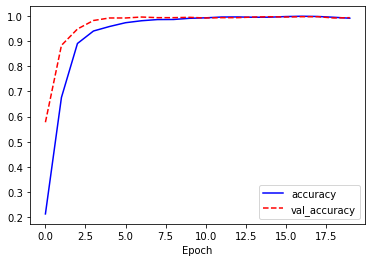

In [31]:
# Plot accuracy
plt.plot(history.history['accuracy'],'b-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [32]:
# 결과 확인
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(class_name[predicted_label],
                                          100*np.max(predictions_array),
                                          class_name[true_label]),
                                          color=color)
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks(range(N_CLASS), class_name, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(N_CLASS), predictions_array, color="#777777")
    plt.ylim([0,1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

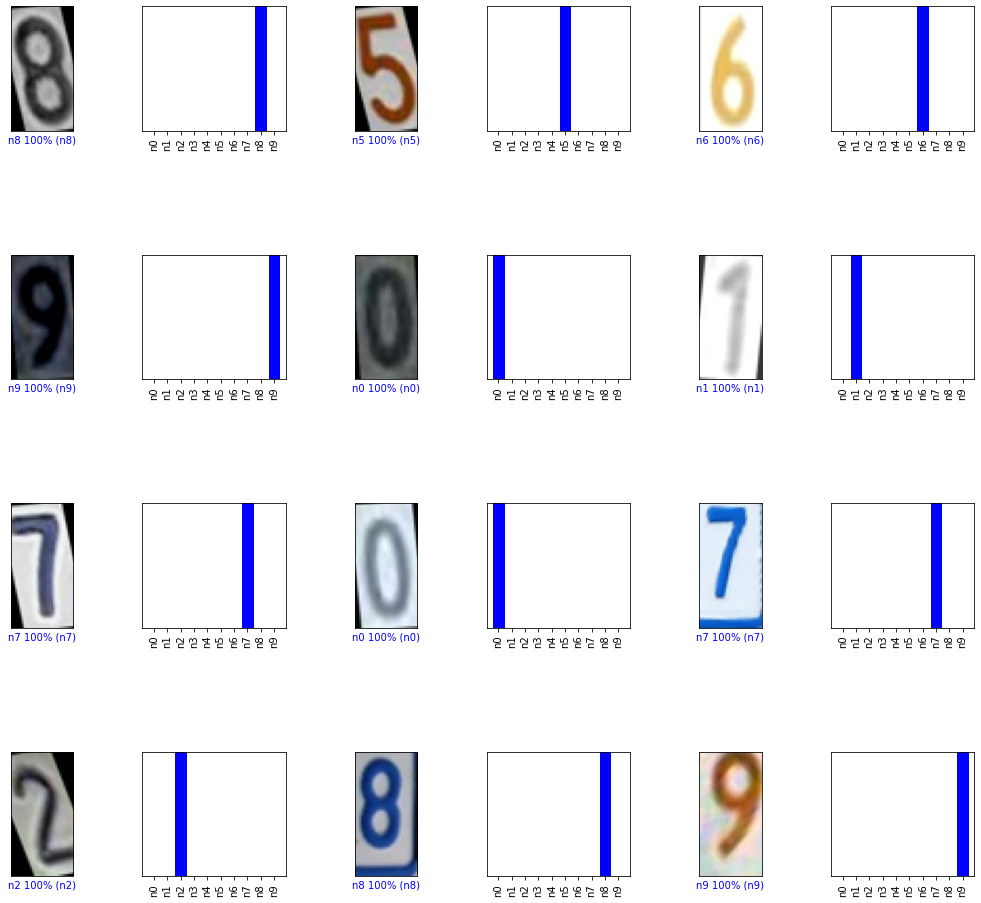

In [33]:
rnd_idx = np.random.randint(1, N_TEST//N_BATCH)
img_cnt = 0
for images, labels in test_dataset:
    img_cnt += 1
    if img_cnt != rnd_idx:
        continue
    predictions = model(images, training=False)
    num_rows=4
    num_cols=3
    num_images = num_rows*num_cols
    labels = tf.argmax(labels, axis=-1)
    plt.figure(figsize=(3*2*num_cols, 4*num_rows))
    plt.subplots_adjust(hspace=1.0)
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions.numpy(), labels.numpy())
    break

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_gen = ImageDataGenerator(
    rescale = 1./255,
    # 증식  
    rotation_range = 40,       # 회전 (40도 범위 내에서 변형)
    width_shift_range = 0.2,   # 좌우이동 (20% 범위 내에서)
    height_shift_range = 0.15,  # 상하이동 (10% 범위 내에서) - 상하이동은 이미지에 영향을 많이 주기 때문에 적게
    shear_range = 0.2,         # 기울림
    zoom_range = 0.2,          # 확대 축소
    horizontal_flip = True,    # 좌우반전(상하반전은 상하대칭인 경우만 적용)
    fill_mode = "nearest"      # 변형에 따라 이미지 깨지는 부분을 보상
)

test_gen = datagen.flow_from_directory(
    directory = 'C:/Users/smhrd/DeepStudy/num',    
    target_size = (65, 180),  
    batch_size = 20,         
    class_mode = "categorical"
)

In [34]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

h = model.fit_generator(train_gen, epochs=100, validation_data = test_gen)

model.save('num_model2.h5')

Answer :  [5]



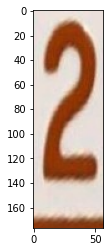

In [43]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import cv2
model = load_model('num_model.h5')
img = cv2.imread('./num/n2/2726_jpg.rf.429a08f6fc13607883110350236cbd73 (2).jpg')
plt.imshow(img)

img = np.resize(img, (1, 30,60,3))
test_num = ((np.array(img)/255)-1)*-1
print("Answer : ", model.predict_classes(test_num))
print()

In [44]:
import easyocr
reader = easyocr.Reader(['ko', 'en']) 
result = reader.readtext('./num/n2/2726_jpg.rf.429a08f6fc13607883110350236cbd73 (2).jpg') 
print(result)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[0, 3], [57, 3], [57, 149], [0, 149]], '2', 0.9999885559409449)]
